In [ ]:
# Step 1: Unzip the dataset
!unzip -q "/content/Dataset_aug.zip" -d .

# Step 2: Imports
import os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     concatenate, Dropout, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Load images
def load_images(input_dir, output_dir, img_size=256):
    image_paths = sorted(glob(os.path.join(input_dir, "*.png")))
    mask_paths = sorted(glob(os.path.join(output_dir, "*.png")))

    X, y = [], []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_size, img_size)) / 255.0
        image = np.expand_dims(image, -1)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size)) / 255.0
        mask = np.expand_dims(mask, -1)

        X.append(image)
        y.append(mask)

    return np.array(X), np.array(y)

X, y = load_images("input", "Output", 256)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# U-Net block
def build_unet(input_tensor, dropout_rate=0.2):
    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        return x

    c1 = conv_block(input_tensor, 32); p1 = MaxPooling2D()(c1)
    c2 = conv_block(p1, 64); p2 = MaxPooling2D()(c2)
    c3 = conv_block(p2, 128); p3 = MaxPooling2D()(c3)
    c4 = conv_block(p3, 256); p4 = MaxPooling2D()(c4)
    c5 = conv_block(p4, 512)

    u6 = concatenate([UpSampling2D()(c5), c4]); c6 = conv_block(u6, 256)
    u7 = concatenate([UpSampling2D()(c6), c3]); c7 = conv_block(u7, 128)
    u8 = concatenate([UpSampling2D()(c7), c2]); c8 = conv_block(u8, 64)
    u9 = concatenate([UpSampling2D()(c8), c1]); c9 = conv_block(u9, 32)

    output = Conv2D(1, 1, activation='sigmoid')(c9)
    return output

# Double U-Net
def build_double_unet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)
    output1 = build_unet(inputs)
    combined = concatenate([inputs, output1])
    output2 = build_unet(combined)
    model = Model(inputs, output2)
    model.compile(optimizer=Adam(3e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_double_unet()

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.5496 - loss: 0.7253 - val_accuracy: 0.9806 - val_loss: 0.5263 - learning_rate: 3.0000e-04
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 65s 690ms/step - accuracy: 0.9006 - loss: 0.5686 - val_accuracy: 0.9806 - val_loss: 0.4164 - learning_rate: 3.0000e-04
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 65s 685ms/step - accuracy: 0.9699 - loss: 0.4534 - val_accuracy: 0.9800 - val_loss: 0.3295 - learning_rate: 3.0000e-04
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 66s 697ms/step - accuracy: 0.9743 - loss: 0.3429 - val_accuracy: 0.9396 - val_loss: 0.3160 - learning_rate: 3.0000e-04
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 66s 693ms/step - accuracy: 0.9766 - loss: 0.2534 - val_accuracy: 0.9219 - val_loss: 0.3561 - learning_rate: 3.0000e-04
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 67s 704ms/step - accuracy: 0.9775 - loss: 0.1881 - val_accuracy: 0.9075 - val_loss: 0.3286 - learning_rate: 3.0000e-04
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 67s 706ms/step - accur

In [ ]:
# Prediction and metrics
y_pred = model.predict(X_test)
y_pred_thresh = (y_pred > 0.5).astype(np.uint8)

def dice_coefficient(y_true, y_pred):
    smooth = 1e-7
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred):
    smooth = 1e-7
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Final Test Scores
dice = dice_coefficient(y_test, y_pred_thresh)
iou = iou_score(y_test, y_pred_thresh)
acc = np.mean((y_test == y_pred_thresh).astype(np.float32))

print(f"✅ Test Accuracy: {acc:.4f}")
print(f"🎯 Test Dice Coefficient: {dice:.4f}")
print(f"📊 Test IoU Score: {iou:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step
✅ Test Accuracy: 0.9825
🎯 Test Dice Coefficient: 0.6979
📊 Test IoU Score: 0.5360


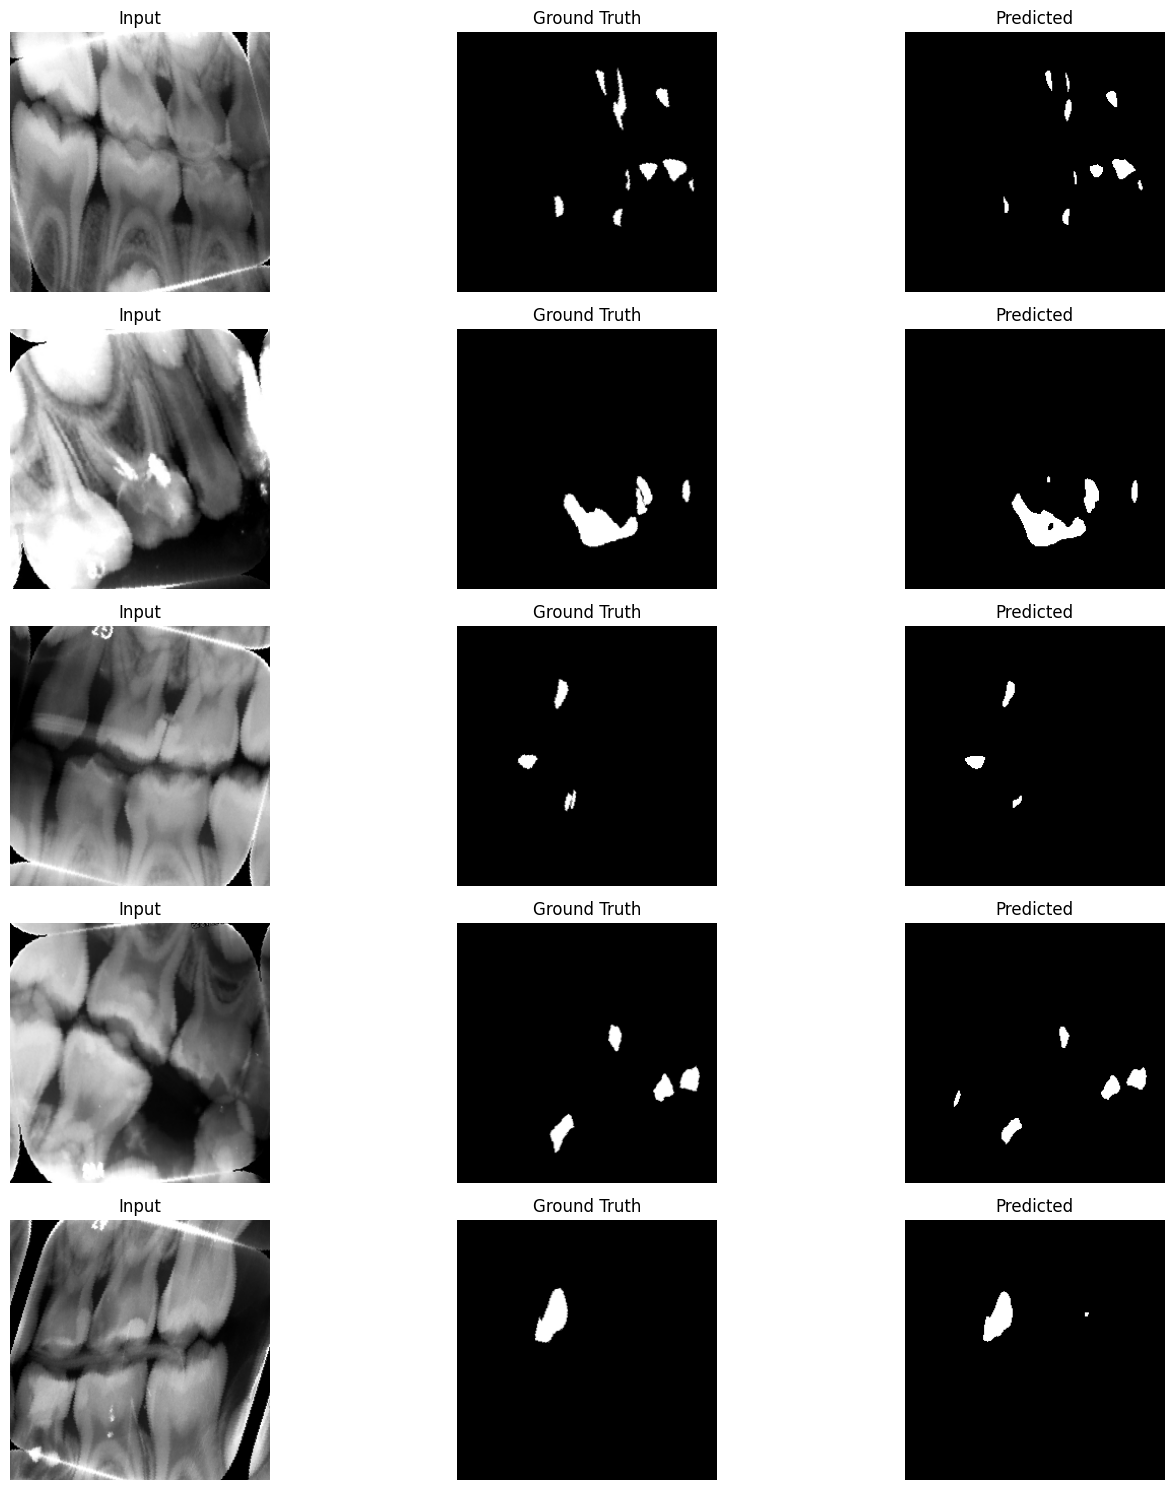

In [ ]:
def show_sample_predictions(X, y_true, y_pred, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title("Input")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title("Predicted")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show a few predictions
show_sample_predictions(X_test, y_test, y_pred_thresh)

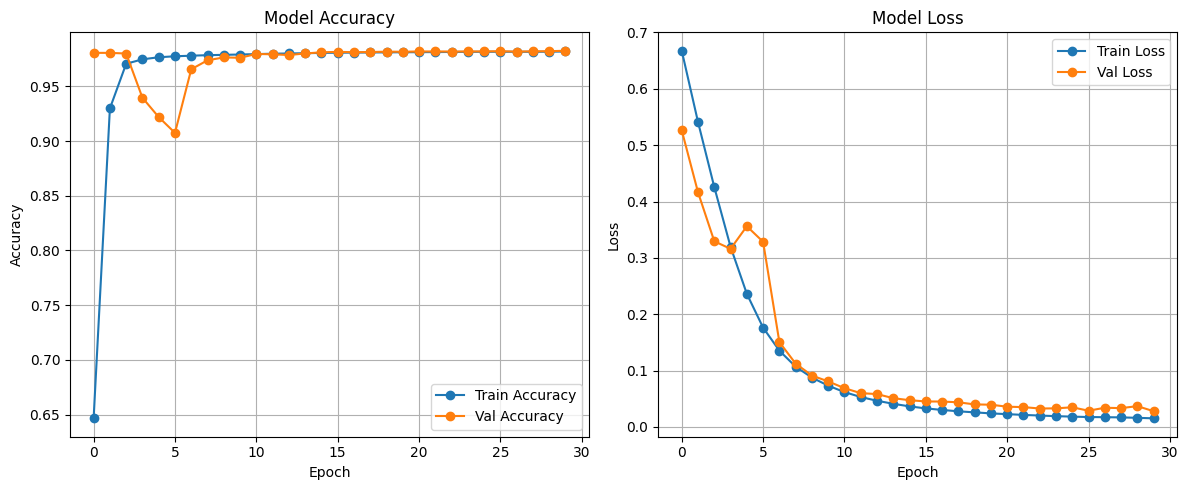

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)

In [ ]:
# Save model
model.save("/content/double_unet.h5")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Flatten predictions and ground truth
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_thresh.flatten()

# Ensure binary labels (0 or 1)
y_test_flat = (y_test_flat > 0.5).astype(np.uint8)
y_pred_flat = (y_pred_flat > 0.5).astype(np.uint8)

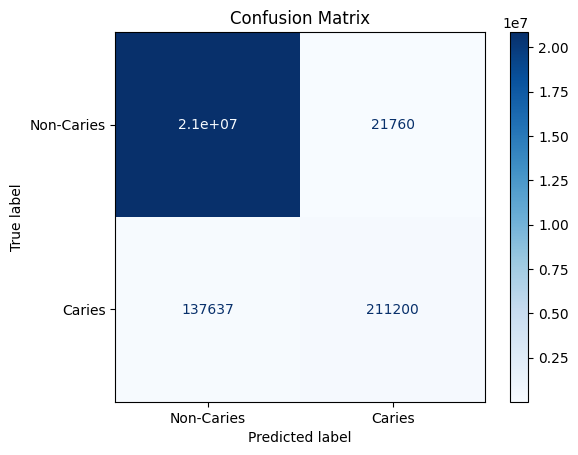

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)

# Display non-normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Caries", "Caries"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

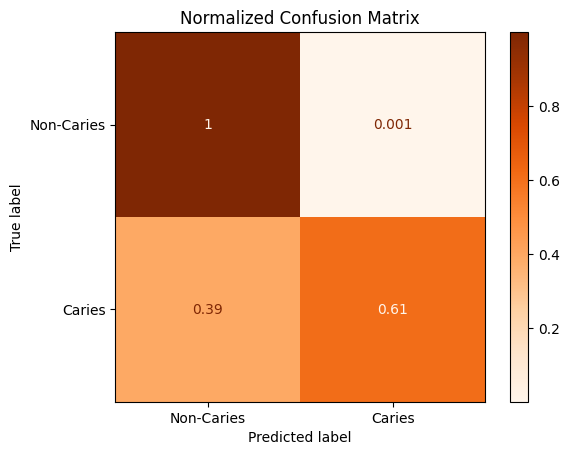

In [ ]:
# Compute normalized confusion matrix (row-wise)
cm_normalized = confusion_matrix(y_test_flat, y_pred_flat, normalize='true')

# Display normalized confusion matrix
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=["Non-Caries", "Caries"])
disp_norm.plot(cmap=plt.cm.Oranges)
plt.title("Normalized Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Flatten to 1D arrays
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_thresh.flatten()

# Binarize
y_test_flat = (y_test_flat > 0.5).astype(np.uint8)
y_pred_flat = (y_pred_flat > 0.5).astype(np.uint8)

In [ ]:
# Generate classification report
report = classification_report(
    y_test_flat, y_pred_flat,
    target_names=["Non-Caries", "Caries"],
    digits=4
)

print("📋 Classification Report:\n")
print(report)

📋 Classification Report:

              precision    recall  f1-score   support

  Non-Caries     0.9934    0.9990    0.9962  20884827
      Caries     0.9066    0.6054    0.7260    348837

    accuracy                         0.9925  21233664
   macro avg     0.9500    0.8022    0.8611  21233664
weighted avg     0.9920    0.9925    0.9918  21233664

